# Image Denoising with Autoencoders

## 
Introduction and Importing Libraries


In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Data Preprocessing


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

## Adding Noise


In [3]:
noisy_x_train = x_train + np.random.rand(60000, 784) * 0.9
noisy_x_test = x_test + np.random.rand(10000, 784) * 0.9

noisy_x_train = np.clip(noisy_x_train, 0.0, 1.0)
noisy_x_test = np.clip(noisy_x_test, 0.0, 1.0)

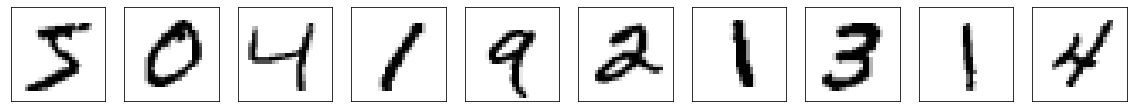

In [4]:
def plot_img(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return
plot_img(x_train, None)

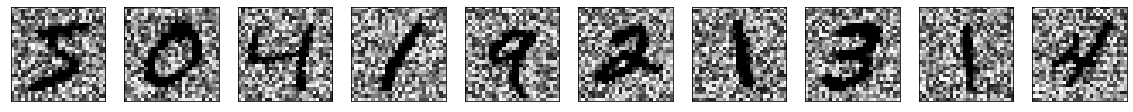

In [5]:
plot_img(noisy_x_train, None)

## Building and Training a Classifier


In [6]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=20, batch_size=512)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 24us/sample - loss: 0.4211 - accuracy: 0.8852
Epoch 2/20
60000/60000 [==============================] - 1s 18us/sample - loss: 0.1525 - accuracy: 0.9555
Epoch 3/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.1022 - accuracy: 0.9699
Epoch 4/20
60000/60000 [==============================] - 1s 17us/sample - loss: 0.0762 - accuracy: 0.9775
Epoch 5/20
60000/60000 [==============================] - 1s 17us/sample - loss: 0.0580 - accuracy: 0.9831
Epoch 6/20
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0462 - accuracy: 0.9858
Epoch 7/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0365 - accuracy: 0.9891
Epoch 8/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0293 - accuracy: 0.9918
Epoch 9/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0235 - accuracy: 0.9935
Epoch 10/20
60

In [7]:
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)

10000/10000 [==============================] - 1s 50us/sample - loss: 0.0827 - accuracy: 0.9798
0.9798


In [8]:
loss, acc = classifier.evaluate(noisy_x_test, y_test)
print(acc)

10000/10000 [==============================] - 0s 46us/sample - loss: 12.2025 - accuracy: 0.2623
0.2623


## Building the Autoencoder


In [9]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

## Training the Autoencoder


In [10]:
autoencoder.fit(
    noisy_x_train, x_train,
    epochs=100, batch_size=512,
    validation_split=0.2, verbose=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

0.256 _0.225 _0.201 _0.185 _0.174 _0.165 _0.156 _0.149 _0.144 _0.139 _0.135 _0.132 _0.129 _0.126 _0.124 _0.122 _0.120 _0.118 _0.117 _0.116 _0.115 _0.114 _0.114 _0.113 _0.112 _0.112 _0.112 _0.111 _0.111 _0.111 _0.110 _0.110 _0.110 _0.110 _0.110 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.109 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _0.108 _  _ 
Training is complete!


## Denoised Images


In [11]:
predictions = autoencoder.predict(noisy_x_test)

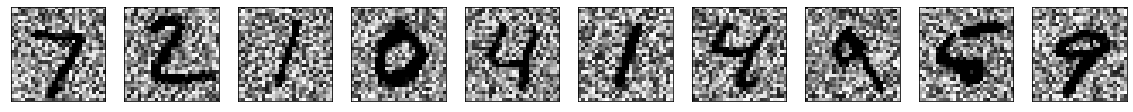

In [12]:
plot_img(noisy_x_test, None)

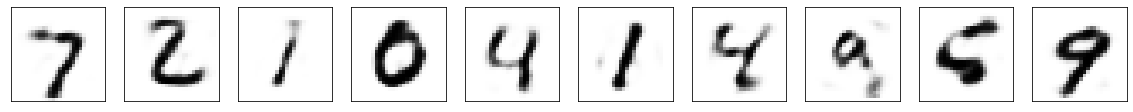

In [13]:
plot_img(predictions, None)

In [14]:
loss, acc = classifier.evaluate(predictions, y_test)
print(acc)

10000/10000 [==============================] - 0s 47us/sample - loss: 0.1967 - accuracy: 0.9551
0.9551


## Composite Model


In [15]:
noisy_image = Input(shape=(784,))
x = autoencoder(noisy_image)
y = classifier(x)

model = Model(noisy_image, y)

In [16]:
p = model.predict(noisy_x_test)

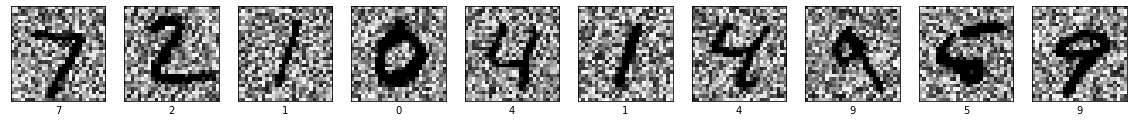

In [17]:
plot_img(noisy_x_test, p, True)

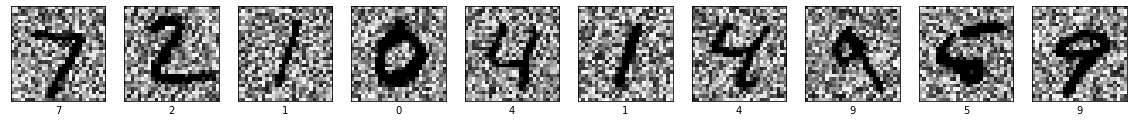

In [19]:
plot_img(noisy_x_test, to_categorical(y_test), True)